# This program is used to achieve fast condensed nearest neighbors¶

One-hot coding is achieved

PCA is compiled

Try reinforcement step

Multigrid strategy is implemented

An improved version of FCNN by sklearn knn

Teacher student developed by cosine distance

Mar. 21, 2021

In [1]:
# import necessary package
import matplotlib.pyplot as plt
import numpy as np

import time

from PIL import Image

from scipy.spatial import distance
from scipy.stats import entropy

from sklearn.decomposition import PCA

from sklearn.neighbors import NearestCentroid

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

101
101
the training image is: 


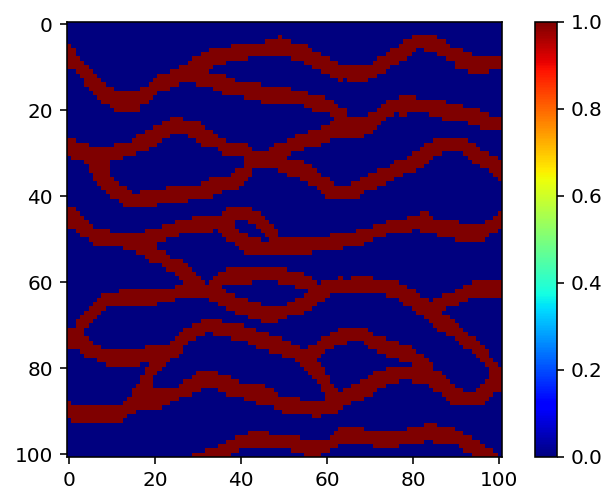

In [2]:
# read the training image
TIBMP = Image.open("channel101.bmp",'r')
TIInt = TIBMP.load()
TI_Width = TIBMP.size[0]
TI_Height = TIBMP.size[1]

TI = np.array(TIBMP)/255
TI = TI[:,:,0]

TI_list = TI.tolist()

print(TI_Width)
print(TI_Height)
print("the training image is: ")
plt.imshow(TI,vmin=0, vmax=1,cmap='jet')
plt.colorbar()
plt.show()

In [3]:
def TemplatePointSequence(template_radius_y,
                          template_radius_x,
                          grid_factor):
    '''determine the sequence about how to create a pattern'''
    
    sequence_y = []
    sequence_x = []
    sequence_distance = []
    
    for point_y in range(-template_radius_y,template_radius_y+1):
        for point_x in range(-template_radius_x,template_radius_x+1):
            sequence_y.append(point_y*grid_factor)
            sequence_x.append(point_x*grid_factor)
            sequence_distance.append(np.sqrt(point_y*point_y+point_x*point_x))
    
    sequence_y = np.array(sequence_y).astype(int)
    sequence_x = np.array(sequence_x).astype(int)
    sequence_distance = np.array(sequence_distance)
            
    rank = np.argsort(sequence_distance)
    
    sequence_y = sequence_y[rank]
    sequence_x = sequence_x[rank]
    
    sequence_y = np.delete(arr=sequence_y,obj=0)
    sequence_x = np.delete(arr=sequence_x,obj=0)
    
#     print(f'The sequence to collect hard data')
#     print(f'Y {sequence_y}')
#     print(f'X {sequence_x}')
    
    return sequence_y.tolist(), sequence_x.tolist()

In [4]:
def ExtractPattern_Training(domain2D_list,
                            center_y,center_x,
                            sequence_y,sequence_x):
    
    '''extract a pattern from training image based on a given location'''
    
    pattern = []
    for relative_y, relative_x in zip(sequence_y,sequence_x):
        pattern.append(domain2D_list[center_y+relative_y][center_x+relative_x])
    return np.array(pattern)

In [5]:
def ExtractPattern_Simulation(domain2D_list,
                              domain_height,domain_width,
                              center_y,center_x,
                              sequence_y,sequence_x,
                              unknownSymbol=-1):
    
    '''extract a pattern from simulation grid based on a given location'''
    
    
    pattern = []
    for relative_y, relative_x in zip(sequence_y,sequence_x):
        point_y = center_y + relative_y
        point_x = center_x + relative_x
        if(point_y>=0 and point_y<domain_height and point_x>=0 and point_x<domain_width):
            pattern.append(domain2D_list[point_y][point_x])
        else:
            pattern.append(unknownSymbol)
    pattern = np.array(pattern)
    knownAmount = np.argwhere(pattern != unknownSymbol).shape[0]
    return pattern, knownAmount

In [6]:
def EncodePattern_OneHotEncoding(pattern_input,patternSize,faciesAmount):
    
    '''convert pattern using one-hot encoding'''
    '''Important warning pattern: original pattern  vector: pattern after one-hot encoding'''
    
    pattern_output = np.zeros((patternSize,faciesAmount))
    
    for index, element in enumerate(pattern_input):
        if(element >= 0):
            pattern_output[index,int(element)] = 1.0
        
    pattern_output = pattern_output.reshape(-1)
    
    return pattern_output

In [7]:
def ConstructPatternBase_Multigrid(TI_list,
                                  TI_Height,TI_Width,
                                  sequence_y, sequence_x,
                                  template_radius_y,template_radius_x, 
                                  grid_factor, 
                                  faciesAmount = 2,unknownSymbol=-1):
    
    '''construct pattern database within the multi-grid framework'''
     
    patternSize = len(sequence_y)   # the dimension of pattern
    
    PatternBase = []
    Pattern_label = []
    
    for center_y in range(grid_factor*template_radius_y,TI_Height-grid_factor*template_radius_y): 
        for center_x in range(grid_factor*template_radius_x,TI_Width-grid_factor*template_radius_x): 
            # extract a pattern
            pattern = ExtractPattern_Training(domain2D_list=TI_list,
                                              center_y=center_y,center_x=center_x,
                                              sequence_y=sequence_y,sequence_x=sequence_x)
            
            # store pattern in database
            PatternBase.extend(pattern.tolist())
            Pattern_label.append(TI_list[center_y][center_x])
            
    PatternBase = np.array(PatternBase).astype(int)
    PatternBase = PatternBase.reshape((-1,patternSize))
            
    return PatternBase, np.array(Pattern_label)

In [8]:
def ConstructPatternBase_Multigrid_OneHotEncoding(TI_list,
                                                  TI_Height,TI_Width,
                                                  sequence_y, sequence_x,
                                                  template_radius_y,template_radius_x, 
                                                  grid_factor, 
                                                  faciesAmount = 2,unknownSymbol=-1):
    
    '''construct pattern database within the multi-grid framework'''
     
    patternSize = len(sequence_y)   # the dimension of pattern
    vectorSize = faciesAmount*patternSize
    
    VectorBase = []
    VectorBase_label = []
    
    for center_y in range(grid_factor*template_radius_y,TI_Height-grid_factor*template_radius_y): 
        for center_x in range(grid_factor*template_radius_x,TI_Width-grid_factor*template_radius_x): 
            # extract a pattern
            pattern = ExtractPattern_Training(domain2D_list=TI_list,
                                              center_y=center_y,center_x=center_x,
                                              sequence_y=sequence_y,sequence_x=sequence_x)
            # convert pattern using one hot encoding
            vector = EncodePattern_OneHotEncoding(pattern_input=pattern,
                                                  patternSize=patternSize,
                                                  faciesAmount=faciesAmount)
            
            # store pattern in database
            VectorBase.extend(vector.tolist())
            VectorBase_label.append(TI_list[center_y][center_x])
            
    VectorBase = np.array(VectorBase).astype(int)
    VectorBase = VectorBase.reshape((-1,vectorSize))
            
    return VectorBase, np.array(VectorBase_label)

In [9]:
def Principal_Component_Analysis(VectorBase):
    
    print('running PCA')
    EnergyThreshold = 0.9
    
    vectorSize = VectorBase.shape[1]
    
    pca = PCA(n_components=vectorSize)
    pca.fit(VectorBase)
    
    varianceVector = pca.explained_variance_ratio_
    cumulativeVarianceVector = np.cumsum(varianceVector)
    SelectDimension = np.searchsorted(cumulativeVarianceVector, EnergyThreshold)+1
    print("The reduced dimension is "+str(SelectDimension))
    
    VectorBase_Decompose = pca.transform(VectorBase)[:,0:SelectDimension]
    
#     fig, ax = plt.subplots()
#     ax.plot(np.linspace(1,vectorSize,vectorSize),cumulativeVarianceVector,color='r',linewidth=2,label='cumulative Variance')
#     ax.legend(loc='upper right')
#     ax.set_yticks(np.linspace(0,1.1,12))
#     ax.set_ylabel('cumulative variance')
#     ax.set_xlabel('dimension')
#     plt.show()
    
    return VectorBase_Decompose

In [10]:
def Fast_condensed_nearest_neighbor(Dataset, Dataset_labels):
    
    '''carry out fast condensed nearest neighbor (FCNN) to remove noisy patterns'''
    
    Num_neighbors = 5
    FCNN_Iteration_Max = 100
    
    
    # find the centroids
    nearest_centroid_instance = NearestCentroid().fit(Dataset, Dataset_labels)
    centroids =  nearest_centroid_instance.centroids_  # centroid is the mean value
    
    knn_instance = NearestNeighbors(n_neighbors = 1,
                                        algorithm = 'ball_tree',
                                        metric = 'euclidean')

    knn_instance.fit(X=Dataset)
    
    neighbors_distance, neighbors_index = knn_instance.kneighbors(X=centroids)
    
    S_indices = np.copy(neighbors_index).reshape(-1)
    S = np.copy(Dataset[S_indices])
    
    iteration_index = 0
    
    Dataset_element_num = Dataset.shape[0]
    
    knn_classifier_instance = KNeighborsClassifier(n_neighbors = 1,
                                                      algorithm = 'auto',
                                                      metric = 'euclidean')
    
    for iteration_index in range(FCNN_Iteration_Max):
        
        if(S_indices.shape[0] < Num_neighbors):
            knn_classifier_instance = KNeighborsClassifier(n_neighbors = 1,
                                                      algorithm = 'auto',
                                                      metric = 'euclidean')
        else:
            knn_classifier_instance = KNeighborsClassifier(n_neighbors = Num_neighbors,
                                                      algorithm = 'auto',
                                                      metric = 'euclidean')
        
        T_indices = np.setdiff1d(np.arange(0,Dataset_element_num,1), S_indices)
        T = np.copy(Dataset[T_indices])
        
        knn_classifier_instance.fit(X = S, y=Dataset_labels[S_indices])
        
        labels_predict = knn_classifier_instance.predict(X = T)
        
        difference = Dataset_labels[T_indices] - labels_predict
        
        misclassified_indices = np.argwhere( difference != 0.0  ).reshape(-1)
        
        if(misclassified_indices.shape[0] == 0):
            break
        
        neighbor_distance, misclassified_medoid_indices = knn_classifier_instance.kneighbors(X = T[misclassified_indices])
        misclassified_medoid_indices = np.unique(misclassified_medoid_indices)
        
        knn_instance.fit(X = T[misclassified_indices])
        
        neighbors_distance, representative_indices = knn_instance.kneighbors(X = S[misclassified_medoid_indices])
        
        alpha_S_indices = T_indices[misclassified_indices[representative_indices]].reshape(-1)
        
        S_indices = np.concatenate((S_indices, alpha_S_indices))
        S_indices = np.unique(S_indices)
        S = np.copy(Dataset[S_indices])

#         plt.scatter(Dataset[:,0], Dataset[:,1],
#                     c=Dataset_labels, cmap='Greens',
#                     s=20, lw=0,
#                     vmin=-1, vmax=2)
#         plt.scatter(Dataset[S_indices,0], Dataset[S_indices,1],
#                     c='r',
#                     s=30, lw=0)
#         plt.scatter(Dataset[alpha_S_indices,0], Dataset[alpha_S_indices,1],
#                     c='b',
#                     s=20, lw=0)
#         plt.xlabel(str('PC1'),fontsize='large')
#         plt.ylabel(str('PC2'),fontsize='large')
#         plt.tick_params(direction='in',labelsize='large')
#         plt.title(f'Iteration {iteration_index} with {S.shape[0]} patterns')
#         plt.show()
        
#         print(f'S indices: {S_indices}')
#         print(f'S labels: {Dataset_labels[S_indices]}')
    
    return np.copy(S_indices)

In [11]:
def ConstructPatternBase_Multigrid_FCNN(TI_list,
                                          TI_Height,TI_Width,
                                          sequence_y, sequence_x,
                                          template_radius_y,template_radius_x, 
                                          grid_factor, 
                                          faciesAmount = 2,unknownSymbol=-1):
    
    print(f'Carrying out fast condensed nearest neighbor')
    
    Dataset, Labels = ConstructPatternBase_Multigrid_OneHotEncoding(TI_list = TI_list,
                                                                TI_Height = TI_Height,
                                                                TI_Width = TI_Width,
                                                                sequence_y = sequence_y,
                                                                sequence_x = sequence_x,
                                                                template_radius_y = template_radius_y,
                                                                template_radius_x = template_radius_x, 
                                                                grid_factor = grid_factor, 
                                                                faciesAmount = Facies_Amount,
                                                                unknownSymbol = UnknownSymbol)


    Dataset_decomposed = Principal_Component_Analysis(VectorBase = Dataset)

    Dataset_resampled_indices = Fast_condensed_nearest_neighbor(Dataset = Dataset_decomposed,
                                                                            Dataset_labels = Labels)
    
#     plt.scatter(Dataset_decomposed[:,0], Dataset_decomposed[:,1], c = Labels, cmap='jet', s=7)
#     plt.title(f'{Dataset_decomposed.shape[0]} Patterns before ENN')
#     plt.show()

#     plt.scatter(Dataset_decomposed[Dataset_resampled_indices,0], Dataset_decomposed[Dataset_resampled_indices,1],
#                 c = Labels[Dataset_resampled_indices], cmap='jet', s=7)
#     plt.title(f'{Dataset_resampled_indices.shape[0]} Patterns after ENN')
#     plt.show()

    print(f'The number of patterns before FCNN {Dataset_decomposed.shape[0]}')
    print(f'The number of patterns after  FCNN {Dataset_resampled_indices.shape}')
    
    return Dataset_resampled_indices

In [12]:
def RandomSimulationPath(domain_height,domain_width,grid_factor):
    '''define the simulation path within the multi-grid framework'''
    
    height = domain_height // grid_factor
    width = domain_width // grid_factor
    
    simulationPath = np.arange(height*width)
    np.random.shuffle(simulationPath)
    
    simulationPath_y = simulationPath // width
    simulationPath_x = simulationPath % width
    simulationPath_y = simulationPath_y * grid_factor
    simulationPath_x = simulationPath_x * grid_factor
    
    return simulationPath_y.astype(int).tolist(), simulationPath_x.astype(int).tolist()

In [13]:
def InitializeRealization2D_unconditional(domain_height,domain_width,sampleRate,faciesAmount=2, unknownSymbol=-1):
    
    '''initialize a realization'''
    
    sampleAmount = int(domain_height*domain_width*sampleRate)
    
    hardDataPath = np.arange(domain_height*domain_width)
    np.random.shuffle(hardDataPath)
    hardDataPath = hardDataPath[:sampleAmount]
    hardDataPath_y = hardDataPath // domain_width
    hardDataPath_x = hardDataPath % domain_width
    
    hardDataValue = np.random.randint(low=0,high=faciesAmount,size=sampleAmount)
    
    Realization2D = np.full(shape=(domain_height,domain_width), fill_value=unknownSymbol)
    
    for center_y, center_x, value in zip(hardDataPath_y, hardDataPath_x, hardDataValue):
        Realization2D[center_y, center_x] = value
    
    return Realization2D

In [14]:
def Migrate_HardData_to_Coarse_Grid(Realization2D,
                                    SG_Height, SG_Width,
                                    MaxGrid,
                                    UnknownSymbol):
    
    grid_factor = 2**MaxGrid
    
    Distance_to_HardData = np.full((SG_Height, SG_Width), fill_value=10000)
    
    for y in range(0, SG_Height):
        for x in range(0, SG_Width):
            
            if(Realization2D[y, x] != UnknownSymbol):
                
                value = Realization2D[y, x]
                
                y_migrated = int((y // grid_factor) * grid_factor)
                x_migrated = int((x // grid_factor) * grid_factor)
                
                distance = (y-y_migrated)**2 + (x-x_migrated)**2
                
                if( distance < Distance_to_HardData[y_migrated, x_migrated]):
                    Realization2D[y_migrated, x_migrated] = value
                    
                    Distance_to_HardData[y_migrated, x_migrated] = distance
                    
    return Realization2D

In [15]:
def Simulate_Realizations_Ball_Tree(TrainingImage,
                                     TrainingImage_list,
                                     TI_Height,
                                     TI_Width,
                                     SG_Amount,
                                     SG_Height,
                                     SG_Width,
                                     MultiGrid,
                                     Template_radius_y,
                                     Template_radius_x,
                                     Num_neighbors,
                                     FaciesAmount,
                                     UnknownSymbol):
    
    print('\n\n\n All patterns and Ball tree searching')
    
    # unconditional simulation
    RealizationSet = []
    for index_realization in range(SG_Amount):    
        SimulationGrid = InitializeRealization2D_unconditional(domain_height = SG_Height,
                                                               domain_width = SG_Width,
                                                               sampleRate = 0.005,
                                                               faciesAmount = FaciesAmount,
                                                               unknownSymbol = UnknownSymbol)
        RealizationSet.extend(SimulationGrid.tolist())
        
    RealizationSet = np.array(RealizationSet)
    RealizationSet = RealizationSet.reshape((SG_Amount, SG_Height, SG_Width))
    
    # migrate hard data to coarsest grid
    for index_realization in range(SG_Amount):
        Realization2D = Migrate_HardData_to_Coarse_Grid(Realization2D = RealizationSet[index_realization],
                                    SG_Height = SG_Height, SG_Width=SG_Width,
                                    MaxGrid = MultiGrid,
                                    UnknownSymbol = UnknownSymbol)
    
    # multigrid strategy
    for grid in np.arange(start=MultiGrid, stop=-1, step=-1):
        
        print(f'Grid {grid}:')
        
        starting_time = time.time()
        
        grid_factor = 2**grid
        
        # define the sequence to collect hard data
        sequence_y, sequence_x = TemplatePointSequence(template_radius_y=Template_radius_y,
                                                  template_radius_x=Template_radius_x,
                                                  grid_factor=grid_factor)
        
        # construct a pattern dataset
        Dataset, Labels = ConstructPatternBase_Multigrid(TI_list = TrainingImage_list,
                                                                TI_Height = TI_Height,
                                                                TI_Width = TI_Width,
                                                                sequence_y = sequence_y,
                                                                sequence_x = sequence_x,
                                                                template_radius_y = Template_radius_y,
                                                                template_radius_x = Template_radius_x, 
                                                                grid_factor = grid_factor, 
                                                                faciesAmount = Facies_Amount,
                                                                unknownSymbol = UnknownSymbol)
        
        ball_tree_instance = NearestNeighbors(n_neighbors = Num_neighbors,
                                            algorithm = 'ball_tree',
                                            metric='hamming')
        ball_tree_instance.fit(Dataset)
        
        ending_time = time.time()
        print(f'The ball tree construction program costs {ending_time-starting_time} seconds')
        
        for index_realization in tqdm(range(SG_Amount)):
            
#             print(f'Realization {index_realization}:')
            
            Realization2D_list = np.copy(RealizationSet[index_realization]).tolist()
            
            # define a random simulation path
            simulationPath_y_list, simulationPath_x_list = RandomSimulationPath(domain_height = SG_Height,
                                                                      domain_width = SG_Width,
                                                                      grid_factor = grid_factor)
            
#             for index_point in tqdm(range(len(simulationPath_y_list))):
#                 unknown_y = simulationPath_y_list[index_point]
#                 unknown_x = simulationPath_x_list[index_point]
            
            for unknown_y, unknown_x in zip(simulationPath_y_list, simulationPath_x_list):
                
                if(Realization2D_list[unknown_y][unknown_x]!=UnknownSymbol):
                    continue
                    
                # find an unknown point
                conditioningPattern, knownAmount = ExtractPattern_Simulation(domain2D_list = Realization2D_list,
                                                                              domain_height = SG_Height,
                                                                              domain_width = SG_Width,
                                                                              center_y = unknown_y,
                                                                              center_x = unknown_x,
                                                                              sequence_y = sequence_y,
                                                                              sequence_x = sequence_x,
                                                                              unknownSymbol = UnknownSymbol)
                
                if(knownAmount == 0):
                    # the conditioning pattern does not have known point
                    # randomly assign a value to the simulating point
                    unknown_value = int(np.random.randint(low=0,high=FaciesAmount,size=1))
                else:
                    # perform a ball tree search to find comparable pattern
                    conditioningPattern = conditioningPattern.reshape((1,-1))
                    
                    patternDistance, similarityIndex = ball_tree_instance.kneighbors(conditioningPattern)
                    
                    similarityIndex = similarityIndex.reshape(-1)
                    
                    unknown_value = int(np.random.choice(a=Labels[similarityIndex],size=1)[0])
                    
                Realization2D_list[unknown_y][unknown_x] = unknown_value
            
            RealizationSet[index_realization] = np.copy(np.array(Realization2D_list))
            
#             plt.imshow(Realization2D_list, cmap='jet')
#             plt.colorbar()
#             plt.show()
            
    return RealizationSet

In [16]:
def Simulate_Realizations_BallTree_FCNN(TrainingImage,
                                     TrainingImage_list,
                                     TI_Height,
                                     TI_Width,
                                     SG_Amount,
                                     SG_Height,
                                     SG_Width,
                                     MultiGrid,
                                     Template_radius_y,
                                     Template_radius_x,
                                     Num_neighbors,
                                     FaciesAmount,
                                     UnknownSymbol):
    
    print('\n\n\n FCNN selection and Ball tree searching')
    
    # unconditional simulation
    RealizationSet = []
    for index_realization in range(SG_Amount):    
        SimulationGrid = InitializeRealization2D_unconditional(domain_height = SG_Height,
                                                               domain_width = SG_Width,
                                                               sampleRate = 0.005,
                                                               faciesAmount = FaciesAmount,
                                                               unknownSymbol = UnknownSymbol)
        RealizationSet.extend(SimulationGrid.tolist())
        
    RealizationSet = np.array(RealizationSet)
    RealizationSet = RealizationSet.reshape((SG_Amount, SG_Height, SG_Width))
    
    # migrate hard data to coarsest grid
    for index_realization in range(SG_Amount):
        Realization2D = Migrate_HardData_to_Coarse_Grid(Realization2D = RealizationSet[index_realization],
                                    SG_Height = SG_Height, SG_Width=SG_Width,
                                    MaxGrid = MultiGrid,
                                    UnknownSymbol = UnknownSymbol)
    
    # multigrid strategy
    for grid in np.arange(start=MultiGrid, stop=-1, step=-1):
        
        print(f'Grid {grid}:')
        
        starting_time = time.time()
        
        grid_factor = 2**grid
        
        # define the sequence to collect hard data
        sequence_y, sequence_x = TemplatePointSequence(template_radius_y=Template_radius_y,
                                                  template_radius_x=Template_radius_x,
                                                  grid_factor=grid_factor)
        
        # construct a pattern dataset
        Dataset, Labels = ConstructPatternBase_Multigrid(TI_list = TrainingImage_list,
                                                                TI_Height = TI_Height,
                                                                TI_Width = TI_Width,
                                                                sequence_y = sequence_y,
                                                                sequence_x = sequence_x,
                                                                template_radius_y = Template_radius_y,
                                                                template_radius_x = Template_radius_x, 
                                                                grid_factor = grid_factor, 
                                                                faciesAmount = Facies_Amount,
                                                                unknownSymbol = UnknownSymbol)
        
        
        FCNN_resample_indices = ConstructPatternBase_Multigrid_FCNN(TI_list = TrainingImage_list,
                                                                TI_Height = TI_Height,
                                                                TI_Width = TI_Width,
                                                                sequence_y = sequence_y,
                                                                sequence_x = sequence_x,
                                                                template_radius_y = Template_radius_y,
                                                                template_radius_x = Template_radius_x, 
                                                                grid_factor = grid_factor, 
                                                                faciesAmount = Facies_Amount,
                                                                unknownSymbol = UnknownSymbol)
        
        Dataset = np.copy(Dataset[FCNN_resample_indices])
        Labels = np.copy(Labels[FCNN_resample_indices])
        
        ball_tree_instance = NearestNeighbors(n_neighbors = Num_neighbors,
                                            algorithm = 'ball_tree',
                                            metric='hamming')
        ball_tree_instance.fit(Dataset)
        
        ending_time = time.time()
        print(f'The FCNN program costs {ending_time-starting_time} seconds')
        
        for index_realization in tqdm(range(SG_Amount)):
            
#             print(f'Realization {index_realization}')
            
            Realization2D_list = np.copy(RealizationSet[index_realization]).tolist()
            
            # define a random simulation path
            simulationPath_y_list, simulationPath_x_list = RandomSimulationPath(domain_height = SG_Height,
                                                                      domain_width = SG_Width,
                                                                      grid_factor = grid_factor)
            
#             for index_point in tqdm(range(len(simulationPath_y_list))):
#                 unknown_y = simulationPath_y_list[index_point]
#                 unknown_x = simulationPath_x_list[index_point]
            
            
            for unknown_y, unknown_x in zip(simulationPath_y_list, simulationPath_x_list):
                
                if(Realization2D_list[unknown_y][unknown_x]!=UnknownSymbol):
                    continue
                    
                # find an unknown point
                conditioningPattern, knownAmount = ExtractPattern_Simulation(domain2D_list = Realization2D_list,
                                                                              domain_height = SG_Height,
                                                                              domain_width = SG_Width,
                                                                              center_y = unknown_y,
                                                                              center_x = unknown_x,
                                                                              sequence_y = sequence_y,
                                                                              sequence_x = sequence_x,
                                                                              unknownSymbol = UnknownSymbol)
                
                if(knownAmount == 0):
                    # the conditioning pattern does not have known point
                    # randomly assign a value to the simulating point
                    unknown_value = int(np.random.randint(low=0,high=FaciesAmount,size=1))
                else:
                    # perform a ball tree search to find comparable pattern
                    conditioningPattern = conditioningPattern.reshape((1,-1))
                    
                    patternDistance, similarityIndex = ball_tree_instance.kneighbors(conditioningPattern)
                    
                    similarityIndex = similarityIndex.reshape(-1)
                    
                    unknown_value = int(np.random.choice(a=Labels[similarityIndex],size=1)[0])
                    
                Realization2D_list[unknown_y][unknown_x] = unknown_value
            
            RealizationSet[index_realization] = np.copy(np.array(Realization2D_list))
            
#             plt.imshow(Realization2D_list, cmap='jet')
#             plt.colorbar()
#             plt.show()
            
    return RealizationSet

In [17]:
def Simulate_Realizations_BallTree_TeacherStudent(TrainingImage,
                                     TrainingImage_list,
                                     TI_Height,
                                     TI_Width,
                                     SG_Amount,
                                     SG_Height,
                                     SG_Width,
                                     MultiGrid,
                                     Template_radius_y,
                                     Template_radius_x,
                                     Num_neighbors,
                                     FaciesAmount,
                                     UnknownSymbol,
                                     SG_Amount_teacher,
                                     Divergence_Threshold):
    
    print('\n\n\n FCNN selection, Teacher student improvement, and Ball tree searching')
    
    # unconditional simulation
    RealizationSet = []
    for index_realization in range(SG_Amount):    
        SimulationGrid = InitializeRealization2D_unconditional(domain_height = SG_Height,
                                                               domain_width = SG_Width,
                                                               sampleRate = 0.005,
                                                               faciesAmount = FaciesAmount,
                                                               unknownSymbol = UnknownSymbol)
        RealizationSet.extend(SimulationGrid.tolist())
        
    RealizationSet = np.array(RealizationSet)
    RealizationSet = RealizationSet.reshape((SG_Amount, SG_Height, SG_Width))
    
    # migrate hard data to coarsest grid
    for index_realization in range(SG_Amount):
        Realization2D = Migrate_HardData_to_Coarse_Grid(Realization2D = RealizationSet[index_realization],
                                    SG_Height = SG_Height, SG_Width=SG_Width,
                                    MaxGrid = MultiGrid,
                                    UnknownSymbol = UnknownSymbol)
    
    # multigrid strategy
    for grid in np.arange(start=MultiGrid, stop=-1, step=-1):
        
        print(f'Grid {grid}:')
        
        starting_time = time.time()
        
        grid_factor = 2**grid
        
        # define the sequence to collect hard data
        sequence_y, sequence_x = TemplatePointSequence(template_radius_y=Template_radius_y,
                                                  template_radius_x=Template_radius_x,
                                                  grid_factor=grid_factor)
        
        
        # construct a pattern dataset
        Dataset, Labels = ConstructPatternBase_Multigrid(TI_list = TrainingImage_list,
                                                                TI_Height = TI_Height,
                                                                TI_Width = TI_Width,
                                                                sequence_y = sequence_y,
                                                                sequence_x = sequence_x,
                                                                template_radius_y = Template_radius_y,
                                                                template_radius_x = Template_radius_x, 
                                                                grid_factor = grid_factor, 
                                                                faciesAmount = Facies_Amount,
                                                                unknownSymbol = UnknownSymbol)
        Labels = Labels.astype(int)
        
        ball_tree_teacher = NearestNeighbors(n_neighbors = Num_neighbors,
                                    algorithm = 'ball_tree',
                                    metric='hamming')
        ball_tree_teacher.fit(Dataset)
        
        FCNN_resample_indices = ConstructPatternBase_Multigrid_FCNN(TI_list = TrainingImage_list,
                                                                TI_Height = TI_Height,
                                                                TI_Width = TI_Width,
                                                                sequence_y = sequence_y,
                                                                sequence_x = sequence_x,
                                                                template_radius_y = Template_radius_y,
                                                                template_radius_x = Template_radius_x, 
                                                                grid_factor = grid_factor, 
                                                                faciesAmount = Facies_Amount,
                                                                unknownSymbol = UnknownSymbol)
        
        
        Student_resample_indices = np.copy(FCNN_resample_indices).tolist()
        
        ball_tree_student = NearestNeighbors(n_neighbors = Num_neighbors,
                                            algorithm = 'ball_tree',
                                            metric='hamming')        
        ending_time = time.time()
        print(f'The FCNN program costs {ending_time-starting_time} seconds')
        
        # teaching step
        print('Teacher simulation')
        for index_realization in tqdm(range(SG_Amount_teacher)):
#             print(f'Teacher realization #{index_realization}')
            
            # get initial realization
            Realization2D_list = np.copy(RealizationSet[index_realization]).tolist()
            
            # update student ball tree
            Dataset_student = np.copy(Dataset[Student_resample_indices])
            Labels_student = np.copy(Labels[Student_resample_indices])
            ball_tree_student.fit(Dataset_student)
            print(f'The shape of student set is {Dataset_student.shape}')
            
            # define a random simulation path
            simulationPath_y_list, simulationPath_x_list = RandomSimulationPath(domain_height = SG_Height,
                                                                      domain_width = SG_Width,
                                                                      grid_factor = grid_factor)
            
#             for index_point in tqdm(range(len(simulationPath_y_list))):
#                 unknown_y = simulationPath_y_list[index_point]
#                 unknown_x = simulationPath_x_list[index_point]
            
            for unknown_y, unknown_x in zip(simulationPath_y_list, simulationPath_x_list):
                
                if(Realization2D_list[unknown_y][unknown_x]!=UnknownSymbol):
                    continue
                    
                # find an unknown point
                conditioningPattern, knownAmount = ExtractPattern_Simulation(domain2D_list = Realization2D_list,
                                                                              domain_height = SG_Height,
                                                                              domain_width = SG_Width,
                                                                              center_y = unknown_y,
                                                                              center_x = unknown_x,
                                                                              sequence_y = sequence_y,
                                                                              sequence_x = sequence_x,
                                                                              unknownSymbol = UnknownSymbol)
                
                if(knownAmount == 0):
                    # the conditioning pattern does not have known point
                    # randomly assign a value to the simulating point
                    unknown_value = int(np.random.randint(low=0,high=FaciesAmount,size=1))
                else:
                    # perform a ball tree search to find comparable pattern
                    conditioningPattern = conditioningPattern.reshape((1,-1))
                    
                    # teacher finding
                    patternDistance, similarityIndex = ball_tree_teacher.kneighbors(conditioningPattern)                  
                    similarityIndex_teacher = np.copy(similarityIndex.reshape(-1))
                    occurrence_teacher = np.bincount(Labels[similarityIndex_teacher],minlength=FaciesAmount)
                    
                    # simulate the unknown point according to the teacher finding
                    unknown_value = int(np.random.choice(a=Labels[similarityIndex_teacher],size=1)[0])
                    
                    # student finding
                    patternDistance, similarityIndex = ball_tree_student.kneighbors(conditioningPattern)                  
                    similarityIndex_student = np.copy(similarityIndex.reshape(-1))
                    occurrence_student = np.bincount(Labels_student[similarityIndex_student],minlength=FaciesAmount)
                    
                    # compare teacher and student's performance
                    # JS divergence
#                     divergence = entropy(probabilities_teacher,probabilities_student)
#                     divergence = divergence + entropy(probabilities_student, probabilities_teacher)
#                     divergence = 0.5 * divergence
                    
                    # cosine distance
                    divergence = distance.cosine(occurrence_teacher, occurrence_student)
                    
                    if(divergence > Divergence_Threshold):
                        # student cannot address this conditioning pattern
                        Student_resample_indices.extend(similarityIndex_teacher.tolist())
                        
#                     print(f'Teacher neighbor indices {similarityIndex_teacher}')
#                     print(f'Teacher neighbor labels {Labels[similarityIndex_teacher]}')
#                     print(f'Teacher neighbor occurrence {occurrence_teacher}')
                    
#                     print(f'Student neighbor indices {similarityIndex_student}')
#                     print(f'Student neighbor labels {Labels_student[similarityIndex_student]}')
#                     print(f'Student neighbor occurrence {occurrence_student}')
                    
#                     print(f'Cosine divergence {divergence}\n')
                    
                Realization2D_list[unknown_y][unknown_x] = unknown_value
            
            # store the simulated result
            RealizationSet[index_realization] = np.copy(np.array(Realization2D_list))
#             plt.imshow(Realization2D_list, cmap='jet')
#             plt.colorbar()
#             plt.title('Teacher realization')
#             plt.show()
            
            # remove redundant element
            Student_resample_indices = np.unique(Student_resample_indices).tolist()
            print(f'The number of student set is {len(Student_resample_indices)}')
        
        
        # update student ball tree
        Dataset_student = np.copy(Dataset[Student_resample_indices])
        Labels_student = np.copy(Labels[Student_resample_indices])
        ball_tree_student.fit(Dataset_student)
        print(f'The shape of student set is {Dataset_student.shape}')
            
        print('Student simulation')
        for index_realization in tqdm(range(SG_Amount_teacher, SG_Amount)):
            
#             print(f'Student Realization {index_realization}')
            
            Realization2D_list = np.copy(RealizationSet[index_realization]).tolist()
            
            # define a random simulation path
            simulationPath_y, simulationPath_x = RandomSimulationPath(domain_height = SG_Height,
                                                                      domain_width = SG_Width,
                                                                      grid_factor = grid_factor)
            
            for unknown_y, unknown_x in zip(simulationPath_y, simulationPath_x):
                
                if(Realization2D_list[unknown_y][unknown_x]!=UnknownSymbol):
                    continue
                    
                # find an unknown point
                conditioningPattern, knownAmount = ExtractPattern_Simulation(domain2D_list = Realization2D_list,
                                                                              domain_height = SG_Height,
                                                                              domain_width = SG_Width,
                                                                              center_y = unknown_y,
                                                                              center_x = unknown_x,
                                                                              sequence_y = sequence_y,
                                                                              sequence_x = sequence_x,
                                                                              unknownSymbol = UnknownSymbol)
                
                if(knownAmount == 0):
                    # the conditioning pattern does not have known point
                    # randomly assign a value to the simulating point
                    unknown_value = int(np.random.randint(low=0,high=FaciesAmount,size=1))
                else:
                    # perform a ball tree search to find comparable pattern
                    conditioningPattern = conditioningPattern.reshape((1,-1))
                    
                    patternDistance, similarityIndex = ball_tree_student.kneighbors(conditioningPattern)
                    
                    similarityIndex = similarityIndex.reshape(-1)
                    
                    unknown_value = int(np.random.choice(a=Labels_student[similarityIndex],size=1)[0])
                    
                Realization2D_list[unknown_y][unknown_x] = unknown_value
            
            RealizationSet[index_realization] = np.copy(np.array(Realization2D_list))
#             plt.imshow(Realization2D_list, cmap='jet')
#             plt.colorbar()
#             plt.title('Student Realization')
#             plt.show()
            
    return RealizationSet

In [18]:
MultiGrid = 2

Template_radius_y = 4
Template_radius_x = 4

SimulationGrid_Num = 10
SimulationGrid_Height = 101
SimualtionGrid_Width = 101

Num_neighbors = 7

Facies_Amount = 2

UnknownSymbol = -1

SG_Amount_teacher = min(5,SimulationGrid_Num)
Divergence_Threshold = 0.1

In [19]:
# perform Ball Tree with all patterns

starting_time = time.time()
Realizations_All_BallTree = Simulate_Realizations_Ball_Tree(TrainingImage = TI,
                                     TrainingImage_list = TI_list,
                                     TI_Height = TI_Height,
                                     TI_Width = TI_Width,
                                     SG_Amount = SimulationGrid_Num,
                                     SG_Height = SimulationGrid_Height,
                                     SG_Width = SimualtionGrid_Width,
                                     MultiGrid = MultiGrid,
                                     Template_radius_y = Template_radius_y,
                                     Template_radius_x = Template_radius_x,
                                     Num_neighbors = Num_neighbors,
                                     FaciesAmount = Facies_Amount,
                                     UnknownSymbol = UnknownSymbol)
ending_time = time.time()
print(f'The simulation program based on all patterns and ball tree searching cost {ending_time-starting_time} seconds')

starting_time = time.time()
Realizations_FCNN_BallTree = Simulate_Realizations_BallTree_FCNN(TrainingImage = TI,
                                     TrainingImage_list = TI_list,
                                     TI_Height = TI_Height,
                                     TI_Width = TI_Width,
                                     SG_Amount = SimulationGrid_Num,
                                     SG_Height = SimulationGrid_Height,
                                     SG_Width = SimualtionGrid_Width,
                                     MultiGrid = MultiGrid,
                                     Template_radius_y = Template_radius_y,
                                     Template_radius_x = Template_radius_x,
                                     Num_neighbors = Num_neighbors,
                                     FaciesAmount = Facies_Amount,
                                     UnknownSymbol = UnknownSymbol)

ending_time = time.time()
print(f'The simulation program based on FCNN patterns and ball tree searching cost {ending_time-starting_time} seconds')

starting_time = time.time()
Realizations_FCNN_BallTree_TeacherStudent = Simulate_Realizations_BallTree_TeacherStudent(TrainingImage = TI,
                                     TrainingImage_list = TI_list,
                                     TI_Height = TI_Height,
                                     TI_Width = TI_Width,
                                     SG_Amount = SimulationGrid_Num,
                                     SG_Height = SimulationGrid_Height,
                                     SG_Width = SimualtionGrid_Width,
                                     MultiGrid = MultiGrid,
                                     Template_radius_y = Template_radius_y,
                                     Template_radius_x = Template_radius_x,
                                     Num_neighbors = Num_neighbors,
                                     FaciesAmount = Facies_Amount,
                                     UnknownSymbol = UnknownSymbol,
                                     SG_Amount_teacher = SG_Amount_teacher,
                                     Divergence_Threshold = Divergence_Threshold)
ending_time = time.time()
print(f'The simulation program based on student patterns and ball tree searching cost {ending_time-starting_time} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]




 All patterns and Ball tree searching
Grid 2:
The ball tree construction program costs 0.10574603080749512 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

Grid 1:
The ball tree construction program costs 0.17453861236572266 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

Grid 0:
The ball tree construction program costs 0.2246110439300537 seconds


100%|██████████| 10/10 [01:38<00:00,  9.86s/it]


The simulation program based on all patterns and ball tree searching cost 130.51166534423828 seconds



 FCNN selection and Ball tree searching
Grid 2:
Carrying out fast condensed nearest neighbor
running PCA
The reduced dimension is 52


  0%|          | 0/10 [00:00<?, ?it/s]

The number of patterns before FCNN 4761
The number of patterns after  FCNN (1655,)
The FCNN program costs 4.37392520904541 seconds


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Grid 1:
Carrying out fast condensed nearest neighbor
running PCA
The reduced dimension is 39


  0%|          | 0/10 [00:00<?, ?it/s]

The number of patterns before FCNN 7225
The number of patterns after  FCNN (1711,)
The FCNN program costs 6.7397449016571045 seconds


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Grid 0:
Carrying out fast condensed nearest neighbor
running PCA
The reduced dimension is 24


  0%|          | 0/10 [00:00<?, ?it/s]

The number of patterns before FCNN 8649
The number of patterns after  FCNN (1070,)
The FCNN program costs 5.988098859786987 seconds


100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


The simulation program based on FCNN patterns and ball tree searching cost 61.405163288116455 seconds



 FCNN selection, Teacher student improvement, and Ball tree searching
Grid 2:
Carrying out fast condensed nearest neighbor
running PCA
The reduced dimension is 52


  0%|          | 0/5 [00:00<?, ?it/s]

The number of patterns before FCNN 4761
The number of patterns after  FCNN (1655,)
The FCNN program costs 4.382567882537842 seconds
Teacher simulation
The shape of student set is (1655, 80)


 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

The number of student set is 2401
The shape of student set is (2401, 80)


 40%|████      | 2/5 [00:01<00:02,  1.12it/s]

The number of student set is 2740
The shape of student set is (2740, 80)


 60%|██████    | 3/5 [00:02<00:01,  1.10it/s]

The number of student set is 3044
The shape of student set is (3044, 80)


 80%|████████  | 4/5 [00:03<00:00,  1.08it/s]

The number of student set is 3226
The shape of student set is (3226, 80)


  0%|          | 0/5 [00:00<?, ?it/s]

The number of student set is 3367
The shape of student set is (3367, 80)
Student simulation


100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Grid 1:
Carrying out fast condensed nearest neighbor
running PCA
The reduced dimension is 39


  0%|          | 0/5 [00:00<?, ?it/s]

The number of patterns before FCNN 7225
The number of patterns after  FCNN (1711,)
The FCNN program costs 6.768439531326294 seconds
Teacher simulation
The shape of student set is (1711, 80)


 20%|██        | 1/5 [00:03<00:15,  3.77s/it]

The number of student set is 3204
The shape of student set is (3204, 80)


 40%|████      | 2/5 [00:08<00:11,  3.91s/it]

The number of student set is 3687
The shape of student set is (3687, 80)


 60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

The number of student set is 4020
The shape of student set is (4020, 80)


 80%|████████  | 4/5 [00:16<00:04,  4.21s/it]

The number of student set is 4265
The shape of student set is (4265, 80)


  0%|          | 0/5 [00:00<?, ?it/s]

The number of student set is 4442
The shape of student set is (4442, 80)
Student simulation


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


Grid 0:
Carrying out fast condensed nearest neighbor
running PCA
The reduced dimension is 24


  0%|          | 0/5 [00:00<?, ?it/s]

The number of patterns before FCNN 8649
The number of patterns after  FCNN (1070,)
The FCNN program costs 6.108401298522949 seconds
Teacher simulation
The shape of student set is (1070, 80)


 20%|██        | 1/5 [00:13<00:54, 13.51s/it]

The number of student set is 2996
The shape of student set is (2996, 80)


 40%|████      | 2/5 [00:29<00:42, 14.24s/it]

The number of student set is 3305
The shape of student set is (3305, 80)


 60%|██████    | 3/5 [00:45<00:29, 14.88s/it]

The number of student set is 3449
The shape of student set is (3449, 80)


 80%|████████  | 4/5 [01:02<00:15, 15.33s/it]

The number of student set is 3631
The shape of student set is (3631, 80)


  0%|          | 0/5 [00:00<?, ?it/s]

The number of student set is 3742
The shape of student set is (3742, 80)
Student simulation


100%|██████████| 5/5 [00:29<00:00,  5.84s/it]

The simulation program based on student patterns and ball tree searching cost 163.28183555603027 seconds


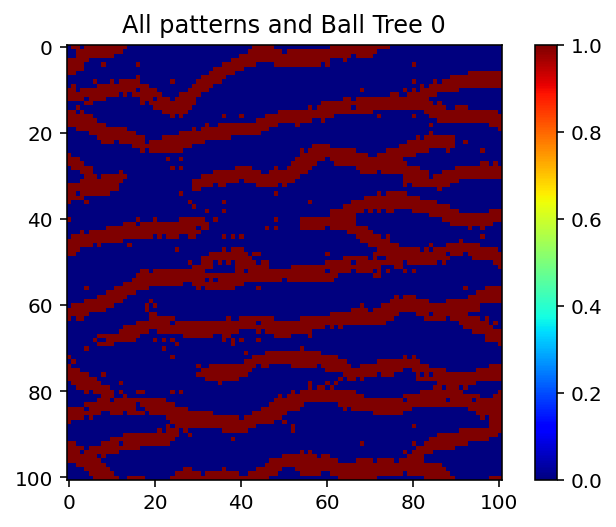

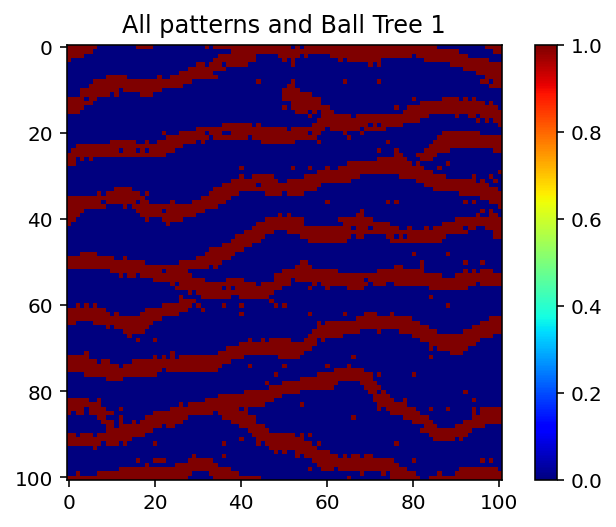

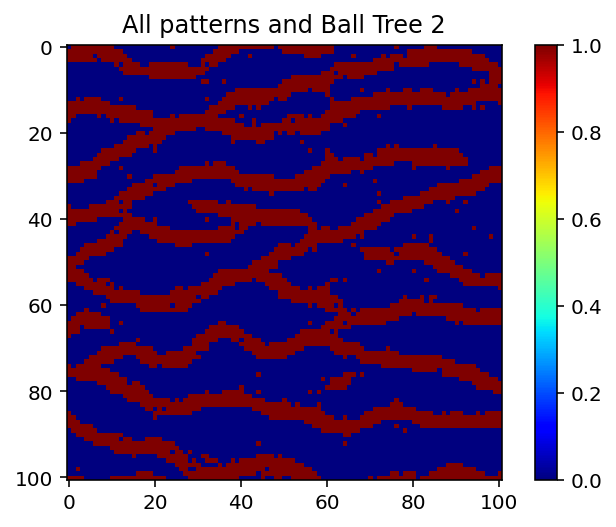

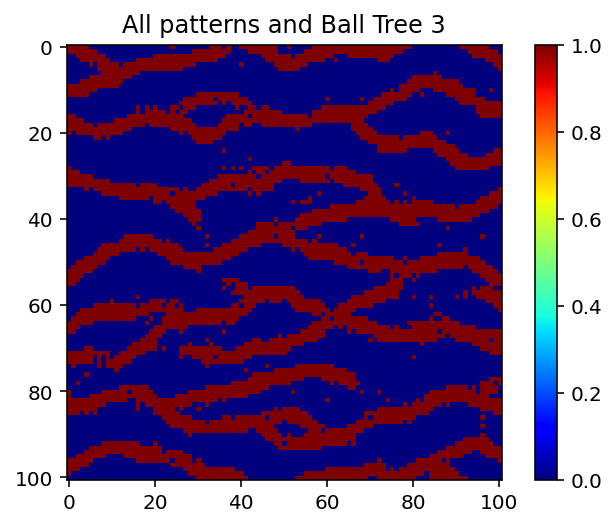

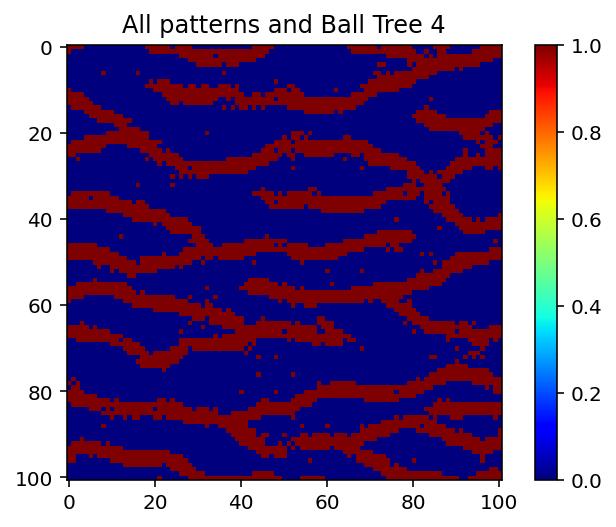

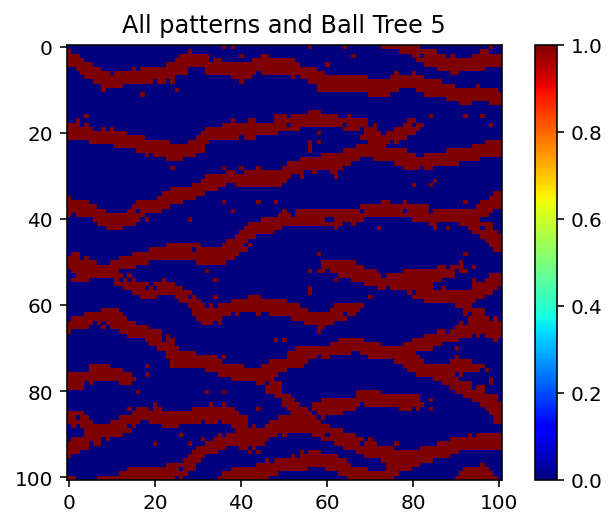

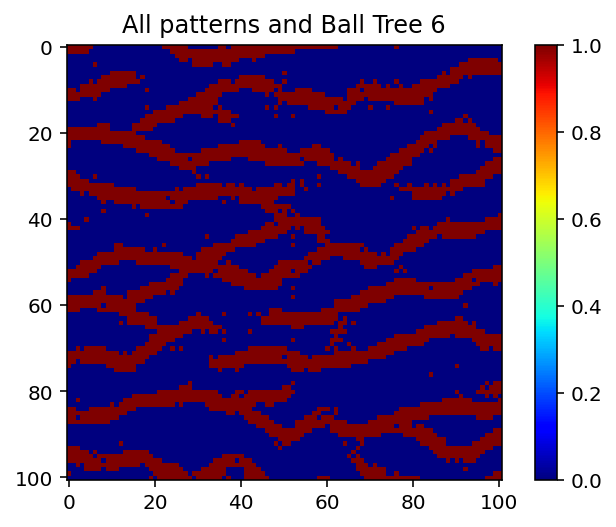

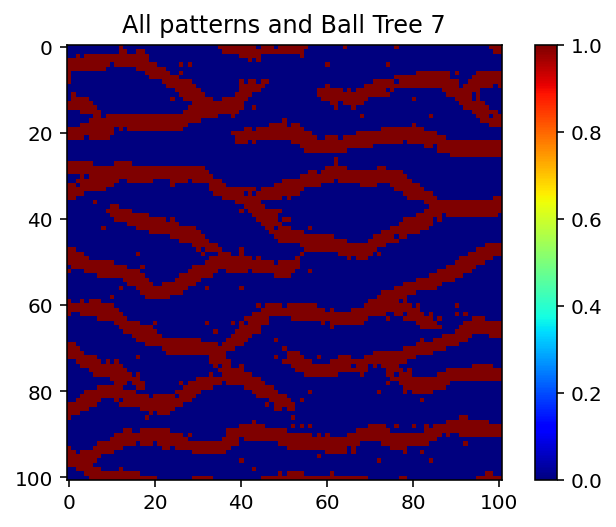

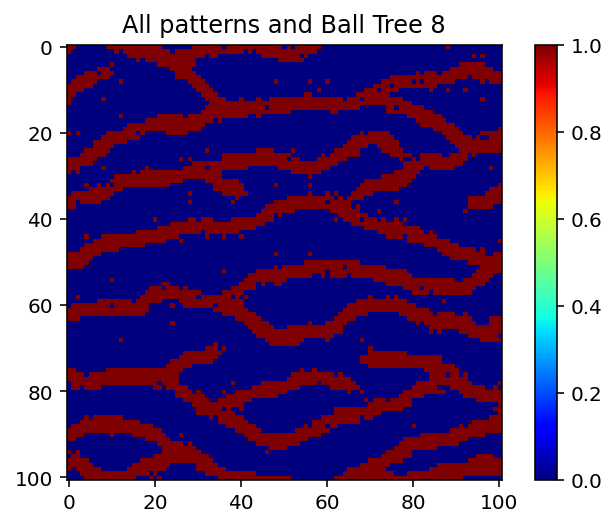

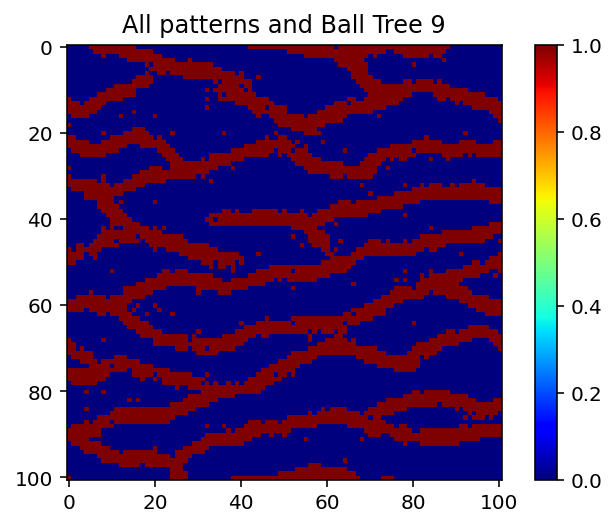

In [20]:
for index_realization in range(SimulationGrid_Num):
    
    plt.imshow(Realizations_All_BallTree[index_realization], cmap='jet')
    plt.colorbar()
    plt.title(f'All patterns and Ball Tree {index_realization}')
    plt.show()

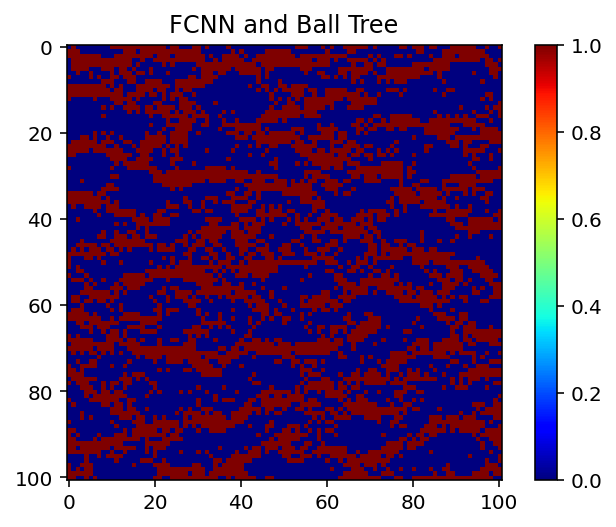

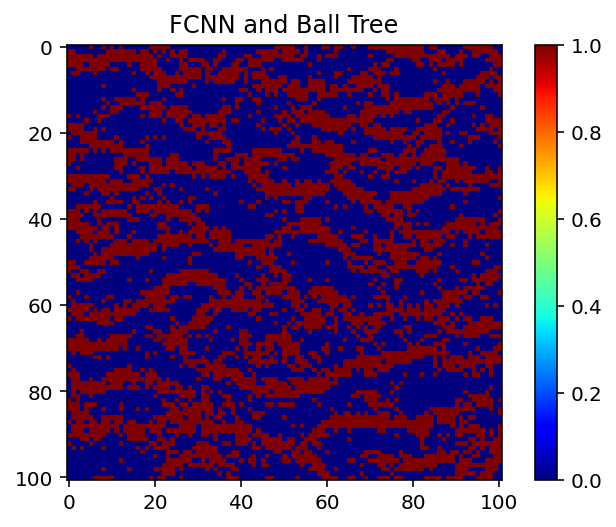

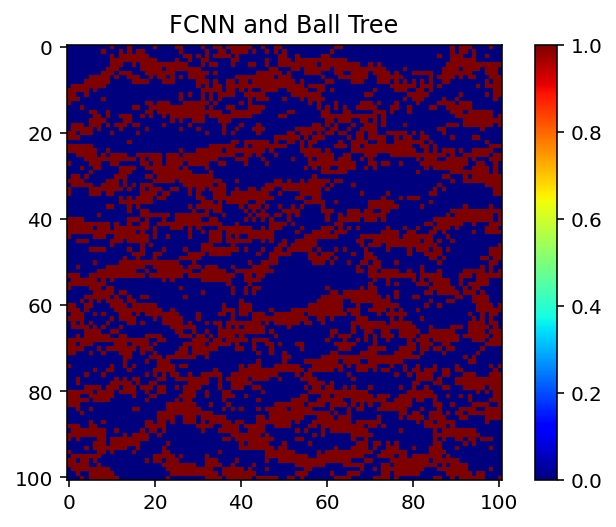

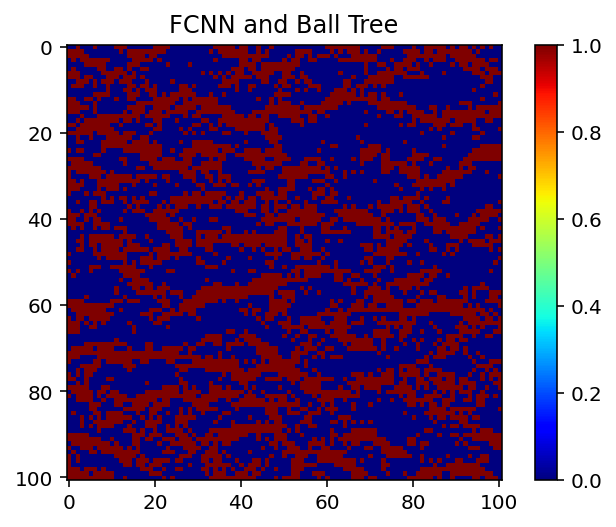

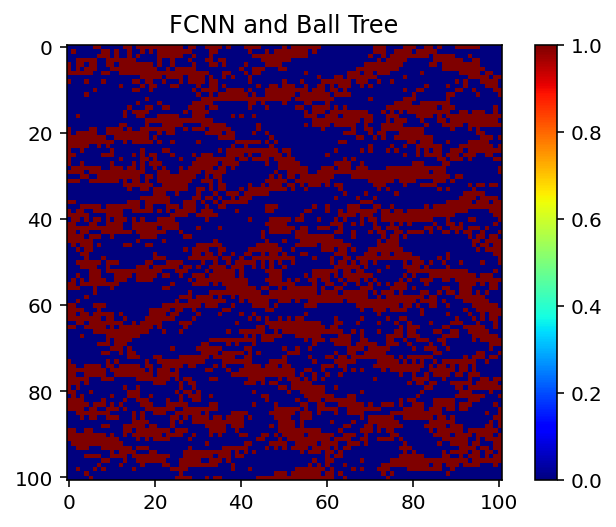

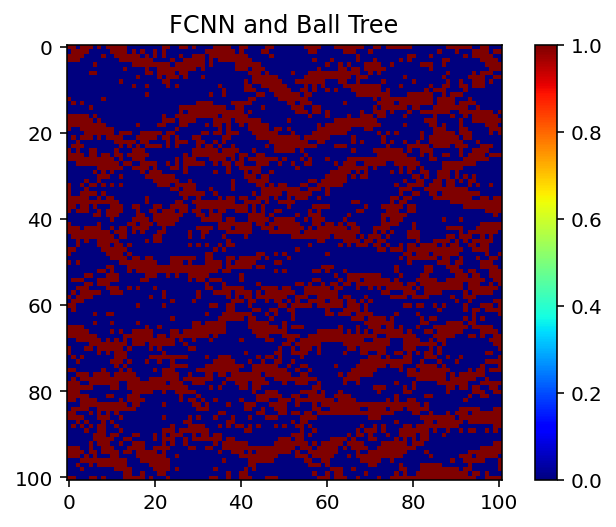

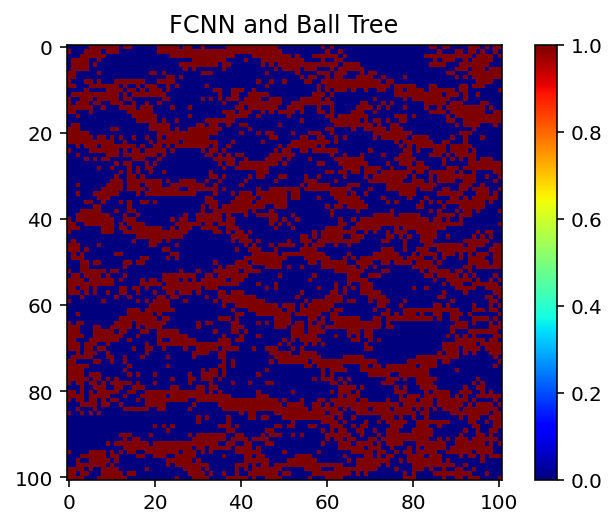

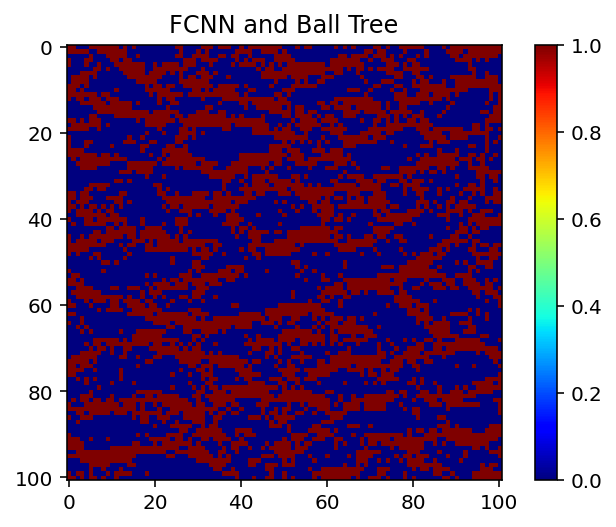

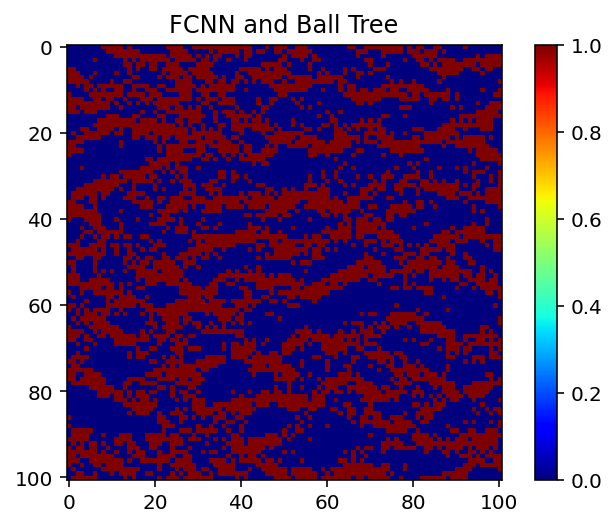

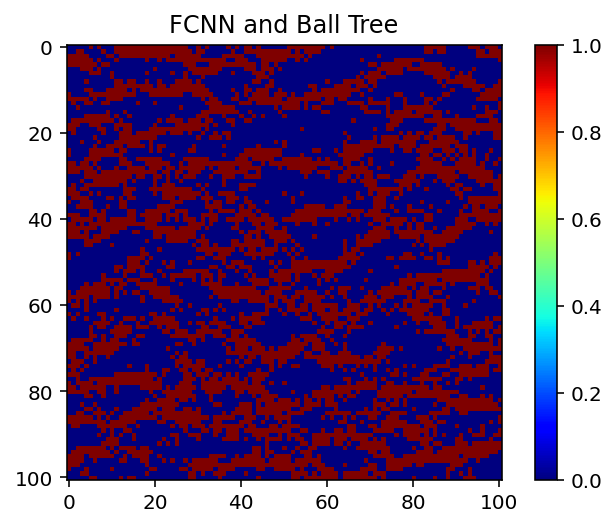

In [24]:
for index_realization in range(SimulationGrid_Num):
    
    plt.imshow(Realizations_FCNN_BallTree[index_realization], cmap='jet')
    plt.colorbar()
    plt.title(f'FCNN and Ball Tree')
    plt.show()

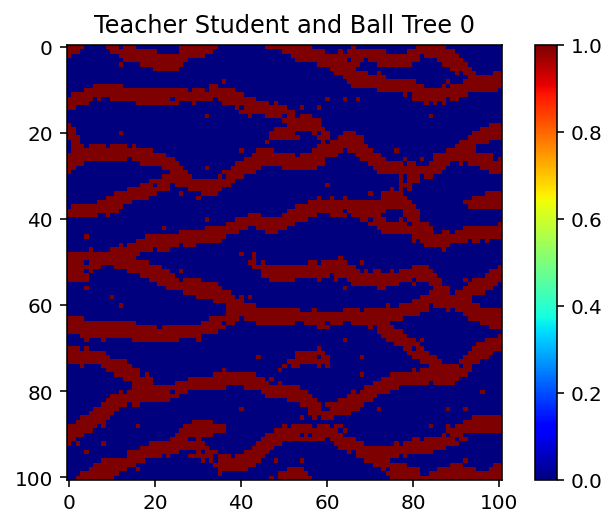

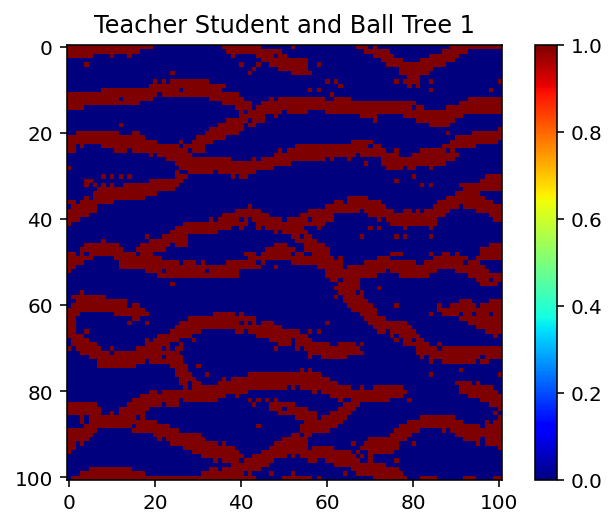

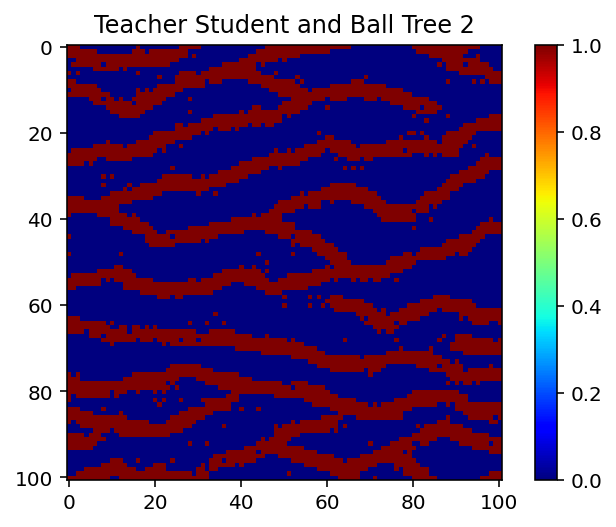

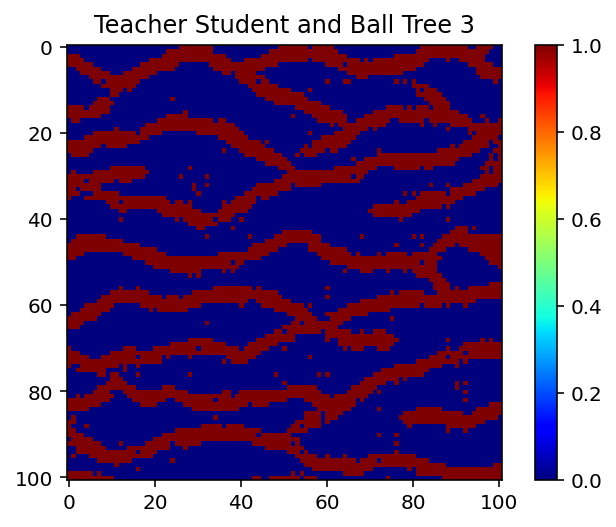

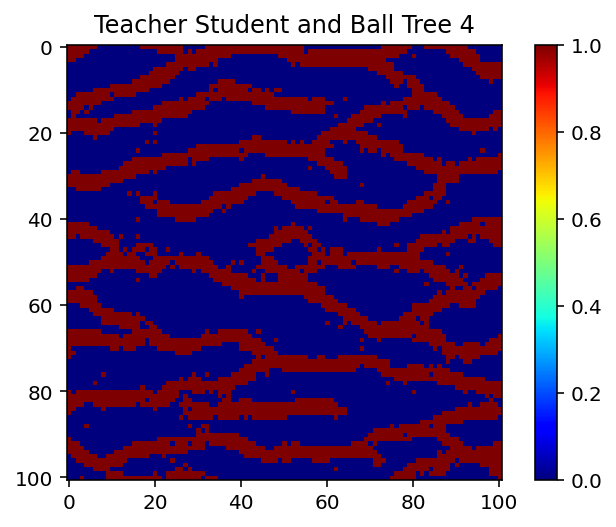

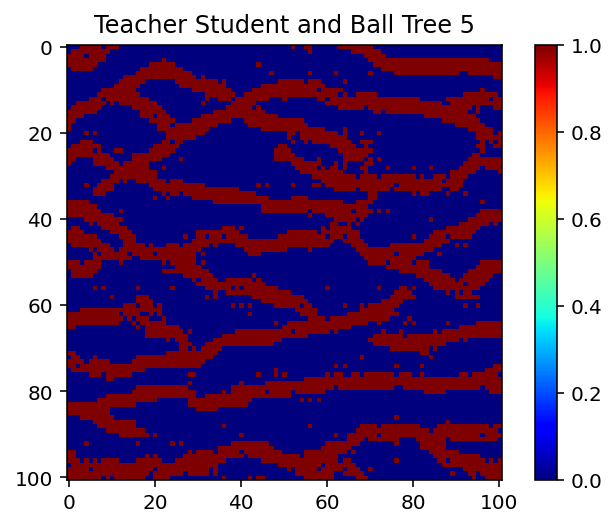

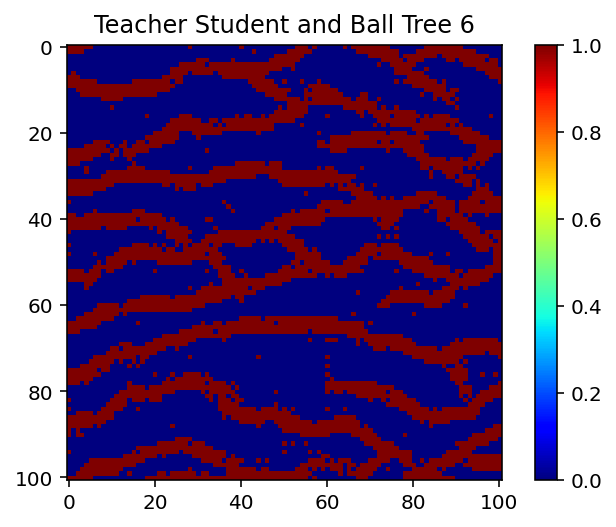

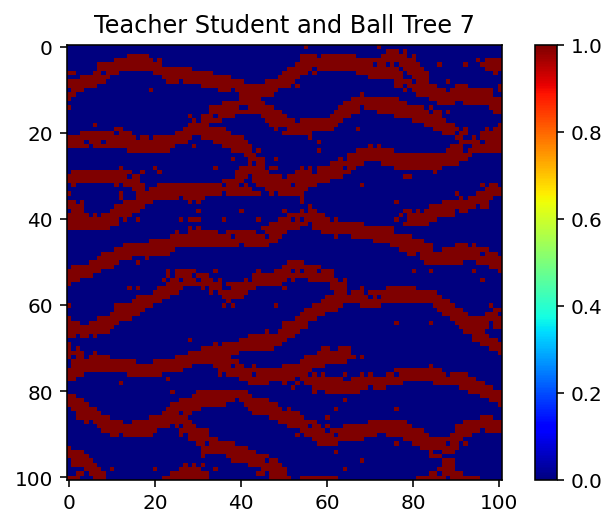

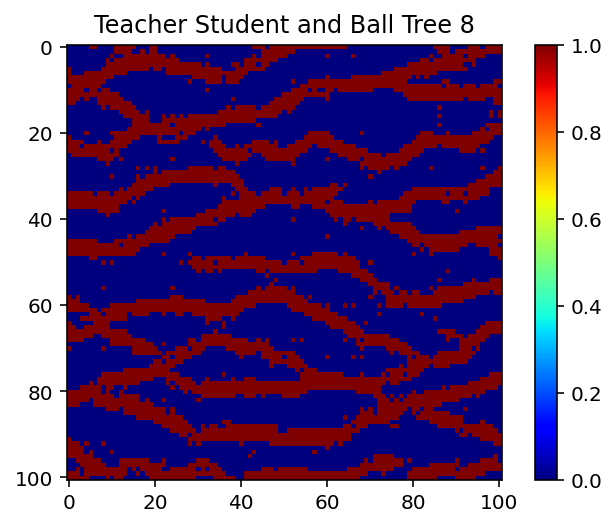

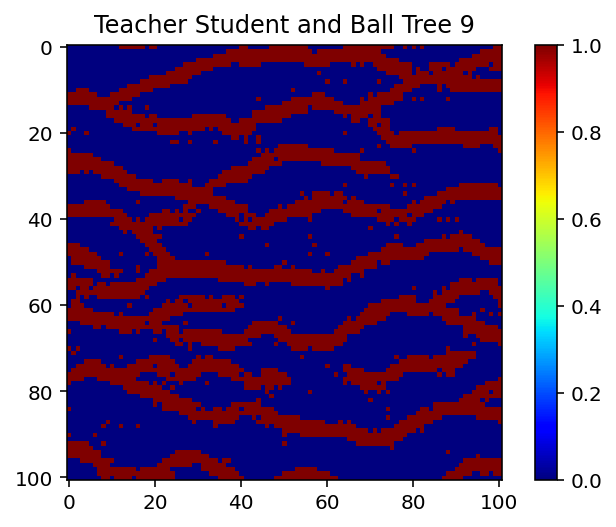

In [22]:
for index_realization in range(SimulationGrid_Num):
    
    plt.imshow(Realizations_FCNN_BallTree_TeacherStudent[index_realization], cmap='jet')
    plt.colorbar()
    plt.title(f'Teacher Student and Ball Tree {index_realization}')
    plt.show()

In [23]:
# np.savetxt(fname='Realizations_All_BallTree_template_radius_4.txt',
#            X=Realizations_All_BallTree.reshape((1,-1)),
#            fmt='%d',delimiter=',')

# np.savetxt(fname='Realizations_FCNN_BallTree.txt',
#            X=Realizations_FCNN_BallTree.reshape((1,-1)),
#            fmt='%d',delimiter=',')

# np.savetxt(fname='Realizations_TeacherStudent_BallTree_template_radius_4.txt',
#            X=Realizations_FCNN_BallTree_TeacherStudent.reshape((1,-1)),
#            fmt='%d',delimiter=',')